In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM,Dense
import matplotlib.pyplot as plt

from keras.models import load_model

Using TensorFlow backend.


In [2]:
df_A = pd.read_csv("../data/graz_don_bosco_no.csv")

In [3]:
df_A['NO']=df_A['Wert']

In [4]:
df_A = df_A['NO']

In [5]:
len(df_A)

287

In [6]:
array = df_A.values.reshape(df_A.shape[0],1)
array[:5]

array([[ 55.723736],
       [149.4827  ],
       [201.86284 ],
       [123.44114 ],
       [ 20.640348]])

In [7]:
#data after normalizing
from sklearn.preprocessing import MinMaxScaler
scl = MinMaxScaler()
array = scl.fit_transform(array)
array[:5]

array([[0.2628896 ],
       [0.73580004],
       [1.        ],
       [0.60444912],
       [0.08593265]])

In [8]:
look_back = 10
forward_days = 3
num_periods = 5

In [9]:
# Spliting the data into train and test bins.
#The Train bin shall be further divdided into train and validate bin
part = len(array) - num_periods*forward_days
array_train = array[:part]
array_test = array[part - look_back:]

In [10]:
#Function that gets some data and splits it in input X and output Y, by spliting in 'm' past days as input X 
#and 'n' coming days as Y.
def processData(data, look_back, forward_days,jump=1):
    X,Y = [],[]
    for i in range(0,len(data) -look_back -forward_days +1, jump):
        X.append(data[i:(i+look_back)])
        Y.append(data[(i+look_back):(i+look_back+forward_days)])
    return np.array(X),np.array(Y)

In [11]:
X_test,y_test = processData(array_test,look_back,forward_days,forward_days)
y_test = np.array([list(a.ravel()) for a in y_test])

X,y = processData(array_train,look_back,forward_days)
y = np.array([list(a.ravel()) for a in y])

from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.10, random_state=7)

In [12]:
NUM_NEURONS_FirstLayer = 50
NUM_NEURONS_SecondLayer = 30
EPOCHS = 30

#Build the model
model = Sequential()
model.add(LSTM(NUM_NEURONS_FirstLayer,input_shape=(look_back,1), return_sequences=True))
model.add(LSTM(NUM_NEURONS_SecondLayer,input_shape=(NUM_NEURONS_FirstLayer,1)))
model.add(Dense(forward_days))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train,y_train,epochs=EPOCHS,validation_data=(X_validate,y_validate),shuffle=True,batch_size=2, verbose=2)





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 234 samples, validate on 26 samples
Epoch 1/30
 - 3s - loss: 0.0084 - val_loss: 0.0074
Epoch 2/30
 - 1s - loss: 0.0074 - val_loss: 0.0069
Epoch 3/30
 - 1s - loss: 0.0067 - val_loss: 0.0073
Epoch 4/30
 - 1s - loss: 0.0064 - val_loss: 0.0083
Epoch 5/30
 - 1s - loss: 0.0066 - val_loss: 0.0070
Epoch 6/30
 - 2s - loss: 0.0062 - val_loss: 0.0085
Epoch 7/30
 - 1s - loss: 0.0063 - val_loss: 0.0094
Epoch 8/30
 - 1s - loss: 0.0060 - val_loss: 0.0066
Epoch 9/30
 - 1s - loss: 0.0060 - val_loss: 0.0074
Epoch 10/30
 - 1s - loss: 0.0060 - val_loss: 0.0100
Epoch 11/30
 - 1s - loss: 0.0062 - val_loss: 0.0077
Epoch 12/30
 - 1s - loss: 0.0060 - val_loss: 0.0075
Epoch 13/30
 - 1s - loss: 0.0061 - val_loss: 0.0086
Epoch 14/30
 - 1s - loss: 0.0062 - val_loss: 0.0079
Epoch 15/30
 - 2s - loss: 0.0061 - val_loss: 0.0082
Epoch 16/30
 - 1s - loss: 0.0061 - val_loss: 0.0086
Epoch 17/30
 - 1s - loss: 0.0063

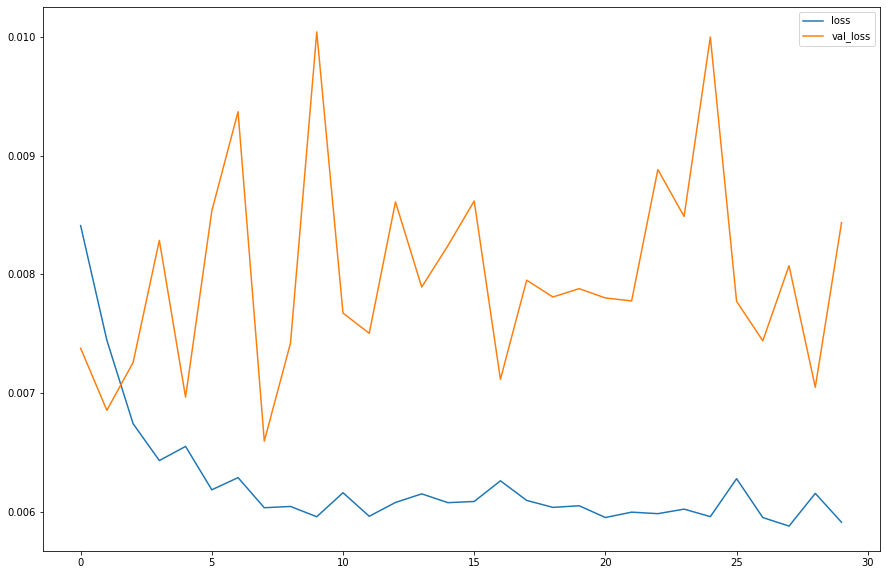

In [13]:
plt.figure(figsize = (15,10))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

In [15]:
#Saving the model
file_name = '../models/LSTM_compX_100epoch.h5'.format(look_back, forward_days, EPOCHS, NUM_NEURONS_FirstLayer, NUM_NEURONS_SecondLayer)
model.save(file_name)
print("Saved model `{}` to disk".format(file_name))

Saved model `../models/LSTM_compX_100epoch.h5` to disk


In [16]:
Xt = model.predict(X_test)

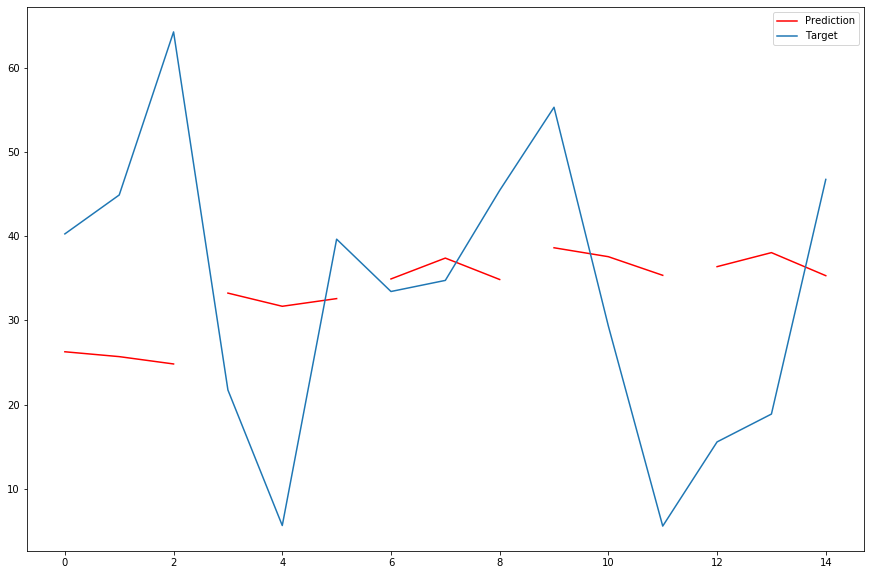

In [17]:

plt.figure(figsize = (15,10))

for i in range(0,len(Xt)):
    plt.plot([x + i*forward_days for x in range(len(Xt[i]))], scl.inverse_transform(Xt[i].reshape(-1,1)), color='r')
    
plt.plot(0, scl.inverse_transform(Xt[i].reshape(-1,1))[0], color='r', label='Prediction') #only to place the label
    
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)), label='Target')
plt.legend(loc='best')
plt.show()